In [33]:
import pandas as pd
import numpy as np

In [34]:
emicron = pd.read_csv("/Users/henriquerodrigues/Desktop/LSE/PP422/Project/Data/emicron_clean.csv")

In [35]:
for i in range(len(emicron)):
    cond1=0
    cond2=0
    if (emicron.at[i, 'P1633'] == 1): 
        cond1=1
    if (emicron.at[i, 'P1055'] == 1):
        cond2=1
    emicron.at[i, "II_D1"] = cond1+cond2

In [36]:
for i in range(len(emicron)):
    # only onwer
    if emicron.at[i, 'P3091']==1:
        cond1= 0
        cond2=0
        # pays H,P and ARL
        if (emicron.at[i, 'P3088']==1):
            cond1=2
        if(emicron.at[i, 'P3090']==1):
            cond2=2
        emicron.at[i, 'II_D2']=cond1+cond2

    # owner and employees
    else:
        cond1= 0
        cond2=0
        cond3=0
        cond4=0
        # pays H,P to owner
        if (emicron.at[i, 'P3088']==1):
            cond1 = 1
        # pays ARL to owner
        if (emicron.at[i, 'P3090']==1):
            cond2=1
        # pays H,P to workers
        if (emicron.at[i, 'P3080']==1):
            cond3=1
       # pays ARL to workers     
        if (emicron.at[i, 'P3084']==1):
            cond4=1
        emicron.at[i, 'II_D2']= cond1+cond2+cond3+cond4

In [37]:
for i in range(len(emicron)):
    # pays tax on profits or not eligible
    if emicron.at[i, 'P2991'] in [1,3]:
        renta = 1
    # Nan, doesn't pay or doesn't want to say
    else:
        renta=0
    # iva
    if emicron.at[i, 'P2992'] in [1,3]:
        iva = 1
    else:
        iva=0
    # ica
    if emicron.at[i, 'P2993'] in [1,3]:
        ica = 1
    else:
        ica=0
    emicron.at[i, 'II_D3']=renta+iva+ica    

In [38]:
for i in range(len(emicron)):
    # doesn't have accounting system
    if emicron.at[i, 'P640'] == 5:
        emicron.at[i, "II_D4"] = 0
    # informal accounting
    elif emicron.at[i, 'P640'] in [3]:
        emicron.at[i, "II_D4"] = 1
    #formal accounting
    elif emicron.at[i, 'P640'] in [1, 2, 4]:
        emicron.at[i, "II_D4"] = 2

In [39]:
for i in range(len(emicron)):
    emicron.at[i, 'II'] = emicron.at[i, 'II_D1']+emicron.at[i, 'II_D2']+emicron.at[i, 'II_D3']+emicron.at[i, 'II_D4']

In [40]:
import matplotlib.pyplot as plt

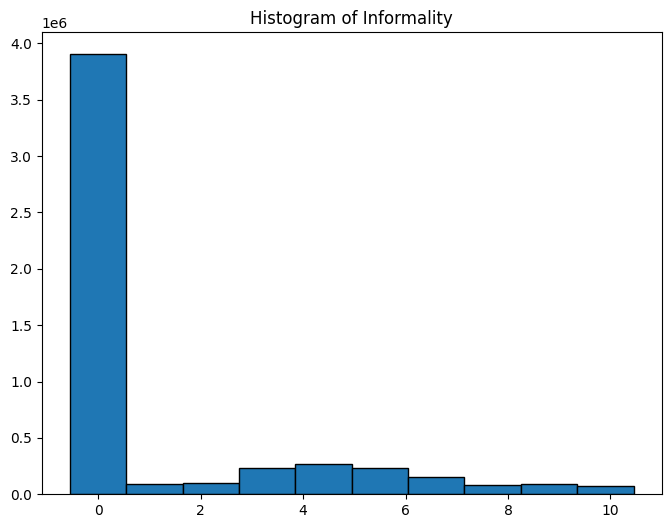

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(emicron.II, edgecolor='black', weights=emicron.F_EXP, align='left')
plt.title("Histogram of Informality")
plt.show()

In [42]:
# dummy for business starting motive
emicron["mot"] = np.where(emicron['P3051'].isin([1, 6]), 1, 0)

In [56]:
# log for monthly spending
emicron['log_gastos']=np.where(emicron['GASTOS_MES']>0, np.log(emicron['GASTOS_MES']), 0)

In [67]:
# log for monthly sales
emicron['log_ventas']=np.where(emicron['VENTAS_MES_ANTERIOR']>0, np.log(emicron['VENTAS_MES_ANTERIOR']), 0)

In [68]:
# zero inflated poisson!!!!
import statsmodels.api as sm

# Assuming 'II' is your outcome variable and 'X' contains predictor variables
# variables:
# CLASE_TE - urban or rural
# P35 - male or female owner
# mot - "good" or "bad" business starting motive
# P639 - how long business operating
# P4001 - use or no use of electronic devices
# P3035 - has "nombre comercial" or not
# log_gastos
# log_ventas

X = emicron[['CLASE_TE', 'P35', 'mot', 'P639', 'P4001', 'log_gastos', 'log_ventas']]
X = sm.add_constant(X)
y = emicron['II']

In [44]:
import seaborn as sns

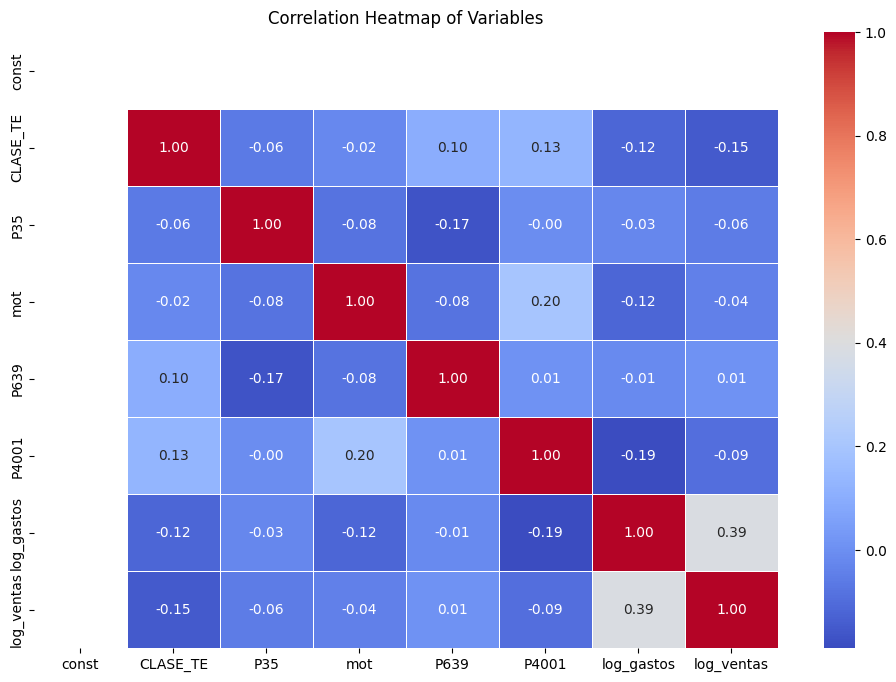

In [69]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Variables')
plt.show()

In [70]:
poisson_model = sm.ZeroInflatedPoisson(endog=y, exog=X, exog_infl=X).fit(maxiter=10**4)

Optimization terminated successfully.
         Current function value: 1.466333
         Iterations: 57
         Function evaluations: 62
         Gradient evaluations: 62


In [71]:
print(poisson_model.summary())

                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                      II   No. Observations:                85862
Model:             ZeroInflatedPoisson   Df Residuals:                    85854
Method:                            MLE   Df Model:                            7
Date:                 Wed, 10 Apr 2024   Pseudo R-squ.:                  0.1489
Time:                         22:02:01   Log-Likelihood:            -1.2590e+05
converged:                        True   LL-Null:                   -1.4793e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const         -2.3335      0.095    -24.468      0.000      -2.520      -2.147
inflate_CLASE_TE       0.5278      0.024     21.782      0.000       0.480       0.575
inflate_P35 

In [60]:
nb = sm.ZeroInflatedNegativeBinomialP(endog=y, exog=X, exog_infl=X).fit(maxiter=10**4)

Optimization terminated successfully.
         Current function value: 1.429256
         Iterations: 79
         Function evaluations: 85
         Gradient evaluations: 85


In [61]:
print(nb.summary())

                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                II   No. Observations:                85862
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    85855
Method:                                      MLE   Df Model:                            6
Date:                           Wed, 10 Apr 2024   Pseudo R-squ.:                  0.1081
Time:                                   21:59:40   Log-Likelihood:            -1.2272e+05
converged:                                  True   LL-Null:                   -1.3760e+05
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const         -4.4277      0.188    -23.606      0.000      -4.795      -4.060
inflate_CLASE_TE   